# Part C: Market Basket Analysis (Association Rule Mining)

This notebook performs association rule mining on the Star Schema warehouse to discover
which products are frequently purchased together.

**Key insight:** TransactionID in this dataset is a row-level ID, NOT a real transaction.
A "transaction" (basket) is defined as: **(CustomerID + Date + Location)**.
A customer performs at most one in-store and one online purchase on a single day.

We perform two levels of analysis:
1. **Category-level**: Which product categories are bought together?
2. **Product-level**: Which specific products are bought together?

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import sqlite3
import os

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns

WAREHOUSE_DIR = os.path.join('..', 'warehouse')
REPORT_DIR = os.path.join('..', 'report')
REPORT_VIZ_DIR = os.path.join(REPORT_DIR, 'visualizations')
REPORT_DATA_DIR = os.path.join(REPORT_DIR, 'data')
DB_FILE = os.path.join(WAREHOUSE_DIR, 'sales_warehouse.db')

os.makedirs(REPORT_VIZ_DIR, exist_ok=True)
os.makedirs(REPORT_DATA_DIR, exist_ok=True)

/Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/_fontconfig_pattern.py:64: PyparsingDeprecationWarning: 'oneOf' deprecated - use 'one_of'
  prop = Group((name + Suppress("=") + comma_separated(value)) | oneOf(_CONSTANTS))
/Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/_fontconfig_pattern.py:85: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/_fontconfig_pattern.py:89: PyparsingDeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/_fontconfig_pattern.py:85: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/_fontconfig_pattern.py:89: PyparsingDeprecationWarning: 'resetCache' deprecated - use 're

In /Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle: 'resetCache' deprecated - use 'reset_cache'


In /Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle: 'parseString' deprecated - use 'parse_string'


In /Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle: 'resetCache' deprecated - use 'reset_cache'


In /Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle: 'parseString' deprecated - use 'parse_string'


In /Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle: 'resetCache' deprecated - use 'reset_cache'


In /Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle: 'parseString' deprecated - use 'parse_string'


In /Users/shin/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle: 'resetCache' deprecated - use 'reset_cache'


## 1. Load Data from Warehouse

In [2]:
conn = sqlite3.connect(DB_FILE)

query = '''
    SELECT 
        f.sale_id,
        c.customer_name AS customer_id,
        d.full_date,
        d.month,
        d.month_name,
        d.year,
        d.is_weekend,
        p.product_name,
        p.category,
        f.quantity,
        f.price,
        f.total_spent,
        f.location
    FROM FactSales f
    JOIN DimDate d ON f.date_id = d.date_id
    JOIN DimProduct p ON f.product_id = p.product_id
    JOIN DimCustomer c ON f.customer_id = c.customer_id;
'''

df = pd.read_sql(query, conn)
conn.close()

print(f'Loaded {len(df)} sales records from warehouse')
df.head()

Loaded 11362 sales records from warehouse


,sale_id,customer_id,full_date,month,month_name,year,is_weekend,product_name,category,quantity,price,total_spent,location
0,1,CUST_09,2024-04-08,4,April,2024,0,Item_10_Pat,Patisserie,10,18.5,185.0,Online
1,2,CUST_22,2023-07-23,7,July,2023,1,Item_17_Milk,Milk Products,9,29.0,261.0,Online
2,3,CUST_02,2022-10-05,10,October,2022,0,Item_12_But,Butchers,2,21.5,43.0,Online
3,4,CUST_06,2022-05-07,5,May,2022,1,Item_16_Bev,Beverages,9,27.5,247.5,Online
4,5,CUST_05,2022-10-02,10,October,2022,1,Item_6_Food,Food,7,12.5,87.5,Online


## 2. Construct Transaction Baskets

Group items by **(customer_id, full_date, location)** to form baskets.
Each basket represents one customer's single purchase occasion.

In [3]:
# Group by (customer_id, full_date, location) to form product-level baskets
product_baskets = df.groupby(['customer_id', 'full_date', 'location'])['product_name'].apply(list).reset_index()
product_baskets.columns = ['customer_id', 'full_date', 'location', 'items']
product_baskets['unique_items'] = product_baskets['items'].apply(lambda x: list(set(x)))
product_baskets['unique_count'] = product_baskets['unique_items'].apply(len)

# Also create category-level baskets
cat_baskets = df.groupby(['customer_id', 'full_date', 'location'])['category'].apply(list).reset_index()
cat_baskets.columns = ['customer_id', 'full_date', 'location', 'categories']
cat_baskets['unique_cats'] = cat_baskets['categories'].apply(lambda x: list(set(x)))
cat_baskets['cat_count'] = cat_baskets['unique_cats'].apply(len)

print(f'Total baskets: {len(product_baskets)}')
print(f'Baskets with 2+ unique products: {(product_baskets["unique_count"] >= 2).sum()}')
print(f'Baskets with 2+ unique categories: {(cat_baskets["cat_count"] >= 2).sum()}')
print(f'\nBasket size distribution (products):')
print(product_baskets['unique_count'].value_counts().sort_index())

Total baskets: 10257
Baskets with 2+ unique products: 1032
Baskets with 2+ unique categories: 917

Basket size distribution (products):
unique_count
1    9225
2     967
3      63
4       2
Name: count, dtype: int64


## 3. Category-Level Association Rule Mining

Since the dataset is sparse (most baskets have only 1 item), we first analyze at the
**category level** to find which product categories co-occur in the same baskets.

**Important note on lift interpretation:** Because ~90% of baskets contain items from a single
category only, **all** category-level lift values are below 1.0. A lift < 1.0 indicates that the
two categories co-occur *less* frequently than random chance would predict -- i.e., these are
**anti-correlations** (negative associations), not positive co-purchasing patterns. However,
the relative ranking of pairs by lift remains informative: pairs with lift closer to 1.0
exhibit the weakest anti-correlation, meaning they are the category combinations that come
closest to random co-occurrence.

In [4]:
# Create one-hot encoded category basket matrix
cat_transactions = cat_baskets['unique_cats'].tolist()
te_cat = TransactionEncoder()
te_cat_arr = te_cat.fit(cat_transactions).transform(cat_transactions)
cat_basket_df = pd.DataFrame(te_cat_arr, columns=te_cat.columns_)

print(f'Category basket matrix: {cat_basket_df.shape}')
print(f'Categories: {list(te_cat.columns_)}')

# Run Apriori on category-level baskets
cat_frequent = apriori(cat_basket_df, min_support=0.001, use_colnames=True)
cat_frequent['length'] = cat_frequent['itemsets'].apply(len)
cat_pairs = cat_frequent[cat_frequent['length'] >= 2]
print(f'\nFrequent category pairs (min_support=0.001): {len(cat_pairs)}')

# Generate rules using confidence metric (lift < 1 for all pairs due to data sparsity)
cat_rules = association_rules(cat_frequent, metric='confidence', min_threshold=0.01)
cat_rules = cat_rules.sort_values('lift', ascending=False)
print(f'Category-level rules found: {len(cat_rules)}')

cat_rules['pair'] = cat_rules.apply(
    lambda r: tuple(sorted(set(r['antecedents']) | set(r['consequents']))), axis=1
)

print('\n=== Top Category Association Rules (sorted by Lift) ===')
display(cat_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))

Category basket matrix: (10257, 8)
Categories: ['Beverages', 'Butchers', 'Computers And Electric Accessories', 'Electric Household Essentials', 'Food', 'Furniture', 'Milk Products', 'Patisserie']

Frequent category pairs (min_support=0.001): 28
Category-level rules found: 56

=== Top Category Association Rules (sorted by Lift) ===


,antecedents,consequents,support,confidence,lift
36,(Food),(Electric Household Essentials),0.004485,0.032740,0.235992
37,(Electric Household Essentials),(Food),0.004485,0.032326,0.235992
1,(Beverages),(Butchers),0.004192,0.030583,0.223906
0,(Butchers),(Beverages),0.004192,0.030692,0.223906
10,(Milk Products),(Beverages),0.004192,0.030627,0.223427
11,(Beverages),(Milk Products),0.004192,0.030583,0.223427
20,(Butchers),(Furniture),0.004095,0.029979,0.213091
21,(Furniture),(Butchers),0.004095,0.029106,0.213091
31,(Furniture),(Computers And Electric Accessories),0.003997,0.028413,0.211489
30,(Computers And Electric Accessories),(Furniture),0.003997,0.029753,0.211489


## 4. Product-Level Association Rule Mining

Find specific product-level associations using a lower support threshold.

In [5]:
# Create one-hot encoded product basket matrix
prod_transactions = product_baskets['unique_items'].tolist()
te_prod = TransactionEncoder()
te_prod_arr = te_prod.fit(prod_transactions).transform(prod_transactions)
prod_basket_df = pd.DataFrame(te_prod_arr, columns=te_prod.columns_)

print(f'Product basket matrix: {prod_basket_df.shape}')

# Run Apriori on product-level baskets with very low min_support
prod_frequent = apriori(prod_basket_df, min_support=0.0001, use_colnames=True)
prod_frequent['length'] = prod_frequent['itemsets'].apply(len)
prod_pairs = prod_frequent[prod_frequent['length'] >= 2]
print(f'\nFrequent product pairs (min_support=0.0001): {len(prod_pairs)}')

if len(prod_pairs) > 0:
    prod_rules = association_rules(prod_frequent, metric='confidence', min_threshold=0.001)
    prod_rules = prod_rules.sort_values('lift', ascending=False)
    prod_rules['pair'] = prod_rules.apply(
        lambda r: tuple(sorted(set(r['antecedents']) | set(r['consequents']))), axis=1
    )
    print(f'Product-level rules found: {len(prod_rules)}')
    print('\n=== Top 20 Product Association Rules by Lift ===')
    display(prod_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))
else:
    prod_rules = pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift', 'pair'])
    print('No frequent product pairs found.')

Product basket matrix: (10257, 200)



Frequent product pairs (min_support=0.0001): 48
Product-level rules found: 96

=== Top 20 Product Association Rules by Lift ===


,antecedents,consequents,support,confidence,lift
12,(Item_9_Milk),(Item_11_Milk),0.000195,0.200000,19.352830
13,(Item_11_Milk),(Item_9_Milk),0.000195,0.018868,19.352830
1,(Item_10_Bev),(Item_11_Food),0.000195,0.086957,11.892174
0,(Item_11_Food),(Item_10_Bev),0.000195,0.026667,11.892174
65,(Item_22_But),(Item_19_Pat),0.000292,0.030000,11.835000
64,(Item_19_Pat),(Item_22_But),0.000292,0.115385,11.835000
56,(Item_1_Fur),(Item_18_Milk),0.000195,0.033898,7.558585
57,(Item_18_Milk),(Item_1_Fur),0.000195,0.043478,7.558585
77,(Item_21_Bev),(Item_7_Bev),0.000195,0.046512,6.625969
76,(Item_7_Bev),(Item_21_Bev),0.000195,0.027778,6.625969


In [6]:
# Top 5 product-level associations
if len(prod_rules) > 0:
    top_prod_unique = prod_rules.drop_duplicates(subset='pair', keep='first')
    top5 = top_prod_unique.head(5)
else:
    # Fall back to category-level if no product rules
    top5 = cat_rules.drop_duplicates(subset='pair', keep='first').head(5)

print('=== Top 5 Product Associations ===')
for i, (_, row) in enumerate(top5.iterrows(), 1):
    ant = ', '.join(sorted(row['antecedents']))
    con = ', '.join(sorted(row['consequents']))
    print(f"{i}. {ant} -> {con}")
    print(f"   Support: {row['support']:.4f}, Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}")
    print()

# Also show top 5 category associations
top_cat_unique = cat_rules.drop_duplicates(subset='pair', keep='first')
print('\n=== Top 5 Category Associations ===')
for i, (_, row) in enumerate(top_cat_unique.head(5).iterrows(), 1):
    ant = ', '.join(sorted(row['antecedents']))
    con = ', '.join(sorted(row['consequents']))
    print(f"{i}. {ant} -> {con}")
    print(f"   Support: {row['support']:.4f}, Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}")
    print()

=== Top 5 Product Associations ===
1. Item_9_Milk -> Item_11_Milk
   Support: 0.0002, Confidence: 0.2000, Lift: 19.3528

2. Item_10_Bev -> Item_11_Food
   Support: 0.0002, Confidence: 0.0870, Lift: 11.8922

3. Item_22_But -> Item_19_Pat
   Support: 0.0003, Confidence: 0.0300, Lift: 11.8350

4. Item_1_Fur -> Item_18_Milk
   Support: 0.0002, Confidence: 0.0339, Lift: 7.5586

5. Item_21_Bev -> Item_7_Bev
   Support: 0.0002, Confidence: 0.0465, Lift: 6.6260


=== Top 5 Category Associations ===
1. Food -> Electric Household Essentials
   Support: 0.0045, Confidence: 0.0327, Lift: 0.2360

2. Beverages -> Butchers
   Support: 0.0042, Confidence: 0.0306, Lift: 0.2239

3. Milk Products -> Beverages
   Support: 0.0042, Confidence: 0.0306, Lift: 0.2234

4. Butchers -> Furniture
   Support: 0.0041, Confidence: 0.0300, Lift: 0.2131

5. Furniture -> Computers And Electric Accessories
   Support: 0.0040, Confidence: 0.0284, Lift: 0.2115



## 5. Monthly Association Analysis

Perform association rule mining separately for each month to determine if the same
product associations appear across different months.

**Note on date range:** The assignment specifies 48 months of data (Jan 2022 -- Dec 2025).
However, the Kaggle dataset version used (`Retail Store Sales -- 2022-2025` by Ahsan Raza)
contains data only through January 2025, yielding 37 months. This is a limitation of the
dataset, not the methodology. All 37 available months are analyzed below.

### 5a. Category-Level Monthly Analysis

We begin with **category-level** analysis per month since it has better support (8 categories
vs. 200 products means higher co-occurrence rates in each monthly slice).

In [7]:
# Add year-month to baskets
cat_baskets['full_date'] = pd.to_datetime(cat_baskets['full_date'])
cat_baskets['year_month'] = cat_baskets['full_date'].dt.to_period('M')

top5_cat_pairs = top_cat_unique.head(5)['pair'].tolist()
print('Category pairs to track monthly:')
for i, pair in enumerate(top5_cat_pairs, 1):
    print(f'  {i}. {" + ".join(pair)}')

Category pairs to track monthly:
  1. Electric Household Essentials + Food
  2. Beverages + Butchers
  3. Beverages + Milk Products
  4. Butchers + Furniture
  5. Computers And Electric Accessories + Furniture


In [8]:
# Run Apriori per month at category level
monthly_results = []
months_sorted = sorted(cat_baskets['year_month'].unique())
total_months = len(months_sorted)

for ym in months_sorted:
    month_data = cat_baskets[cat_baskets['year_month'] == ym]
    transactions = month_data['unique_cats'].tolist()
    
    if len(transactions) < 5:
        continue
    
    te_m = TransactionEncoder()
    te_arr = te_m.fit(transactions).transform(transactions)
    basket_m = pd.DataFrame(te_arr, columns=te_m.columns_)
    
    try:
        freq = apriori(basket_m, min_support=0.005, use_colnames=True)
        freq['length'] = freq['itemsets'].apply(len)
        freq_pairs = freq[freq['length'] >= 2]
        
        if len(freq_pairs) > 0:
            month_rules = association_rules(freq, metric='confidence', min_threshold=0.005)
            if len(month_rules) > 0:
                month_rules['year_month'] = str(ym)
                month_rules['pair'] = month_rules.apply(
                    lambda r: tuple(sorted(set(r['antecedents']) | set(r['consequents']))),
                    axis=1
                )
                monthly_results.append(month_rules)
    except Exception:
        pass

if not monthly_results:
    # Lower threshold
    for ym in months_sorted:
        month_data = cat_baskets[cat_baskets['year_month'] == ym]
        transactions = month_data['unique_cats'].tolist()
        if len(transactions) < 5:
            continue
        te_m = TransactionEncoder()
        te_arr = te_m.fit(transactions).transform(transactions)
        basket_m = pd.DataFrame(te_arr, columns=te_m.columns_)
        try:
            freq = apriori(basket_m, min_support=0.001, use_colnames=True)
            freq['length'] = freq['itemsets'].apply(len)
            if (freq['length'] >= 2).any():
                month_rules = association_rules(freq, metric='confidence', min_threshold=0.001)
                if len(month_rules) > 0:
                    month_rules['year_month'] = str(ym)
                    month_rules['pair'] = month_rules.apply(
                        lambda r: tuple(sorted(set(r['antecedents']) | set(r['consequents']))),
                        axis=1
                    )
                    monthly_results.append(month_rules)
        except Exception:
            pass

if monthly_results:
    all_monthly = pd.concat(monthly_results, ignore_index=True)
    print(f'Monthly analysis: {len(all_monthly)} total rules across {len(monthly_results)}/{total_months} months')
else:
    all_monthly = pd.DataFrame()
    print('No monthly rules found.')

Monthly analysis: 530 total rules across 37/37 months


In [9]:
# Analyze consistency of associations across months
if len(all_monthly) > 0:
    pair_counts = all_monthly.groupby('pair').agg(
        month_count=('year_month', 'nunique'),
        avg_support=('support', 'mean'),
        avg_confidence=('confidence', 'mean'),
        avg_lift=('lift', 'mean')
    ).reset_index().sort_values('month_count', ascending=False)

    print(f'Total months in dataset: {total_months}')
    print(f'\n=== Most Consistent Category Associations (appear in most months) ===')
    for _, row in pair_counts.head(10).iterrows():
        pair_str = ' + '.join(row['pair'])
        pct = row['month_count'] / total_months * 100
        print(f"  {pair_str}: {row['month_count']}/{total_months} months ({pct:.0f}%), "
              f"avg support={row['avg_support']:.4f}, avg lift={row['avg_lift']:.3f}")

    print(f'\n=== Least Consistent (Seasonal/Sporadic) Associations ===')
    for _, row in pair_counts.tail(5).iterrows():
        pair_str = ' + '.join(row['pair'])
        pct = row['month_count'] / total_months * 100
        print(f"  {pair_str}: {row['month_count']}/{total_months} months ({pct:.0f}%), "
              f"avg support={row['avg_support']:.4f}, avg lift={row['avg_lift']:.3f}")
else:
    pair_counts = pd.DataFrame()
    print('No monthly data available for consistency analysis.')

Total months in dataset: 37

=== Most Consistent Category Associations (appear in most months) ===
  Beverages + Butchers: 13/37 months (35%), avg support=0.0083, avg lift=0.419
  Electric Household Essentials + Food: 13/37 months (35%), avg support=0.0103, avg lift=0.516
  Butchers + Furniture: 13/37 months (35%), avg support=0.0090, avg lift=0.468
  Beverages + Milk Products: 12/37 months (32%), avg support=0.0085, avg lift=0.450
  Butchers + Electric Household Essentials: 12/37 months (32%), avg support=0.0079, avg lift=0.418
  Furniture + Patisserie: 11/37 months (30%), avg support=0.0079, avg lift=0.417
  Electric Household Essentials + Furniture: 11/37 months (30%), avg support=0.0074, avg lift=0.406
  Beverages + Computers And Electric Accessories: 11/37 months (30%), avg support=0.0072, avg lift=0.396
  Butchers + Patisserie: 10/37 months (27%), avg support=0.0078, avg lift=0.383
  Food + Milk Products: 10/37 months (27%), avg support=0.0076, avg lift=0.377

=== Least Consisten

### 5b. Product-Level Monthly Analysis

The assignment asks: *"Do you see the same association between products in different months?"*

While the category-level monthly analysis above provides a high-level view, we also attempt
product-level monthly analysis here. Due to data sparsity (only ~10% of baskets contain 2+
products, and there are 200 unique products), many months will have too few multi-item baskets
to find statistically meaningful product-level associations. We track the top 5 overall product
pairs and check which months they appear in.

In [10]:
# Product-level monthly association analysis
product_baskets['full_date'] = pd.to_datetime(product_baskets['full_date'])
product_baskets['year_month'] = product_baskets['full_date'].dt.to_period('M')

# Get the top 5 overall product pairs to track
top5_prod_pairs = top_prod_unique.head(5)['pair'].tolist()
print('Top 5 product pairs to track monthly:')
for i, pair in enumerate(top5_prod_pairs, 1):
    print(f'  {i}. {" + ".join(pair)}')

# Run Apriori per month at product level
monthly_prod_results = []
prod_months_sorted = sorted(product_baskets['year_month'].unique())
prod_total_months = len(prod_months_sorted)

for ym in prod_months_sorted:
    month_data = product_baskets[product_baskets['year_month'] == ym]
    transactions = month_data['unique_items'].tolist()
    
    if len(transactions) < 5:
        continue
    
    te_m = TransactionEncoder()
    te_arr = te_m.fit(transactions).transform(transactions)
    basket_m = pd.DataFrame(te_arr, columns=te_m.columns_)
    
    try:
        freq = apriori(basket_m, min_support=0.0001, use_colnames=True)
        freq['length'] = freq['itemsets'].apply(len)
        freq_pairs = freq[freq['length'] >= 2]
        
        if len(freq_pairs) > 0:
            month_rules = association_rules(freq, metric='confidence', min_threshold=0.001)
            if len(month_rules) > 0:
                month_rules['year_month'] = str(ym)
                month_rules['pair'] = month_rules.apply(
                    lambda r: tuple(sorted(set(r['antecedents']) | set(r['consequents']))),
                    axis=1
                )
                monthly_prod_results.append(month_rules)
    except Exception:
        pass

if monthly_prod_results:
    all_monthly_prod = pd.concat(monthly_prod_results, ignore_index=True)
    months_with_prod_rules = len(monthly_prod_results)
    print(f'\nProduct-level monthly analysis: {len(all_monthly_prod)} total rules across '
          f'{months_with_prod_rules}/{prod_total_months} months')
    
    # Track top 5 overall product pairs across months
    print(f'\n=== Top 5 Product Pairs: Monthly Presence ===')
    for pair in top5_prod_pairs:
        pair_data = all_monthly_prod[all_monthly_prod['pair'] == pair]
        months_present = pair_data['year_month'].nunique()
        if months_present > 0:
            avg_lift = pair_data['lift'].mean()
            present_months = sorted(pair_data['year_month'].unique())
            print(f'  {" + ".join(pair)}: {months_present}/{prod_total_months} months '
                  f'({months_present/prod_total_months*100:.0f}%), avg lift={avg_lift:.3f}')
            print(f'    Months: {", ".join(present_months)}')
        else:
            print(f'  {" + ".join(pair)}: 0/{prod_total_months} months (0%)')
            print(f'    This pair only appeared in the overall aggregated analysis.')
    
    # Analyze all product-level pair consistency
    prod_pair_counts = all_monthly_prod.groupby('pair').agg(
        month_count=('year_month', 'nunique'),
        avg_support=('support', 'mean'),
        avg_confidence=('confidence', 'mean'),
        avg_lift=('lift', 'mean')
    ).reset_index().sort_values('month_count', ascending=False)
    
    print(f'\n=== Most Consistent Product Associations Across Months ===')
    for _, row in prod_pair_counts.head(10).iterrows():
        pair_str = ' + '.join(row['pair'])
        pct = row['month_count'] / prod_total_months * 100
        print(f"  {pair_str}: {row['month_count']}/{prod_total_months} months ({pct:.0f}%), "
              f"avg support={row['avg_support']:.4f}, avg lift={row['avg_lift']:.3f}")
else:
    all_monthly_prod = pd.DataFrame()
    months_with_prod_rules = 0
    print('\nNo product-level monthly rules found. This is expected given the extreme sparsity.')
    print(f'With 200 products and only ~1,032 multi-item baskets across {prod_total_months} months,')
    print('most individual months have too few co-occurrences for any product pair to meet')
    print('even the minimum support threshold.')

print(f'\n--- Summary ---')
print(f'Category-level monthly: rules found in {len(monthly_results)}/{total_months} months')
print(f'Product-level monthly: rules found in {months_with_prod_rules}/{prod_total_months} months')
if months_with_prod_rules < total_months * 0.5:
    print('The product-level data is significantly sparser than category-level, confirming')
    print('that category-level analysis is more reliable for monthly trend detection.')

Top 5 product pairs to track monthly:
  1. Item_11_Milk + Item_9_Milk
  2. Item_10_Bev + Item_11_Food
  3. Item_19_Pat + Item_22_But
  4. Item_18_Milk + Item_1_Fur
  5. Item_21_Bev + Item_7_Bev



Product-level monthly analysis: 2786 total rules across 37/37 months

=== Top 5 Product Pairs: Monthly Presence ===
  Item_11_Milk + Item_9_Milk: 2/37 months (5%), avg lift=85.333
    Months: 2024-03, 2024-12
  Item_10_Bev + Item_11_Food: 2/37 months (5%), avg lift=139.250
    Months: 2022-02, 2022-08
  Item_19_Pat + Item_22_But: 3/37 months (8%), avg lift=100.190
    Months: 2023-02, 2023-03, 2023-12
  Item_18_Milk + Item_1_Fur: 2/37 months (5%), avg lift=48.958
    Months: 2023-06, 2023-10
  Item_21_Bev + Item_7_Bev: 2/37 months (5%), avg lift=98.875
    Months: 2022-10, 2023-04

=== Most Consistent Product Associations Across Months ===
  Item_19_Pat + Item_22_But: 3/37 months (8%), avg support=0.0039, avg lift=100.190
  Item_22_Cea + Item_2_Bev: 3/37 months (8%), avg support=0.0036, avg lift=44.222
  Item_11_Pat + Item_19_Milk: 3/37 months (8%), avg support=0.0038, avg lift=25.793
  Item_11_Fur + Item_24_Food: 2/37 months (5%), avg support=0.0038, avg lift=32.405
  Item_11_Fur + I

## 6. Visualizations

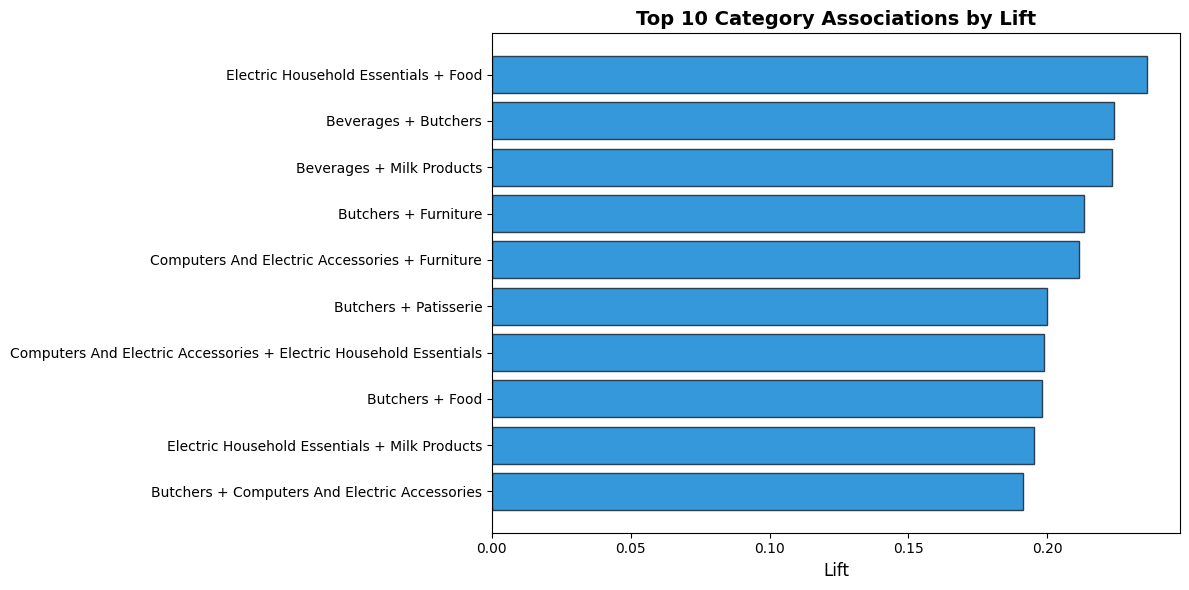

Saved: report/top10_category_associations.png


In [11]:
# Visualization 1: Top category associations by lift
fig, ax = plt.subplots(figsize=(12, 6))
top_cat_10 = cat_rules.drop_duplicates(subset='pair', keep='first').head(10).copy()
top_cat_10['label'] = top_cat_10['pair'].apply(lambda x: ' + '.join(x))
top_cat_10 = top_cat_10.sort_values('lift', ascending=True)

bars = ax.barh(top_cat_10['label'], top_cat_10['lift'], color='#3498db', edgecolor='#2c3e50')
ax.set_xlabel('Lift', fontsize=12)
ax.set_title('Top 10 Category Associations by Lift', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(REPORT_VIZ_DIR, 'top10_category_associations.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: report/top10_category_associations.png')

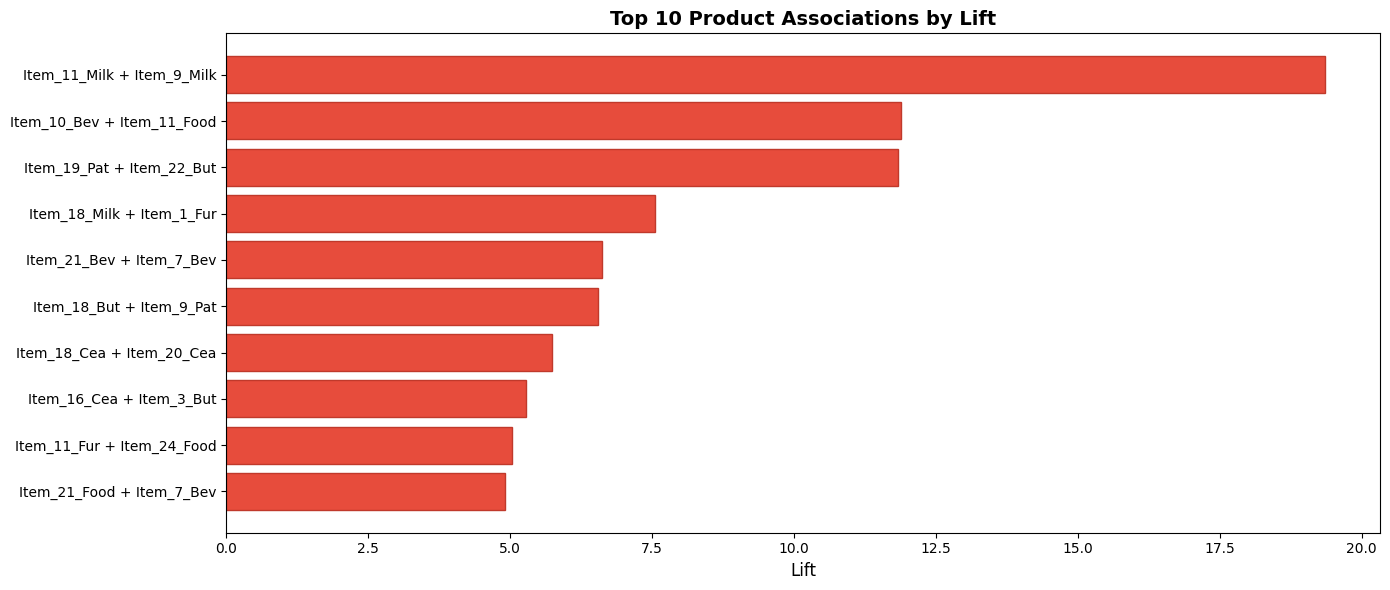

Saved: report/top10_product_associations.png


In [12]:
# Visualization 2: Top product associations by lift
if len(prod_rules) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    top_prod_10 = prod_rules.drop_duplicates(subset='pair', keep='first').head(10).copy()
    top_prod_10['label'] = top_prod_10['pair'].apply(lambda x: ' + '.join(x))
    top_prod_10 = top_prod_10.sort_values('lift', ascending=True)

    ax.barh(top_prod_10['label'], top_prod_10['lift'], color='#e74c3c', edgecolor='#c0392b')
    ax.set_xlabel('Lift', fontsize=12)
    ax.set_title('Top 10 Product Associations by Lift', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(REPORT_VIZ_DIR, 'top10_product_associations.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: report/top10_product_associations.png')
else:
    print('No product-level rules to visualize.')

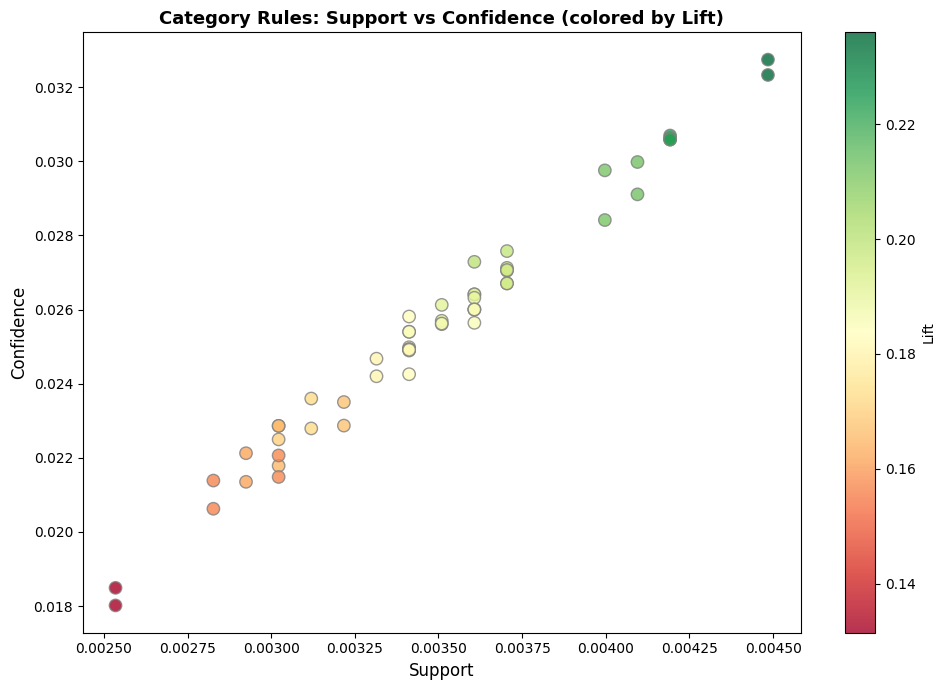

Saved: report/support_vs_confidence.png


In [13]:
# Visualization 3: Support vs Confidence scatter (category level)
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(cat_rules['support'], cat_rules['confidence'],
                     c=cat_rules['lift'], cmap='RdYlGn', s=80, alpha=0.8, edgecolors='gray')
plt.colorbar(scatter, ax=ax, label='Lift')
ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_title('Category Rules: Support vs Confidence (colored by Lift)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(REPORT_VIZ_DIR, 'support_vs_confidence.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: report/support_vs_confidence.png')

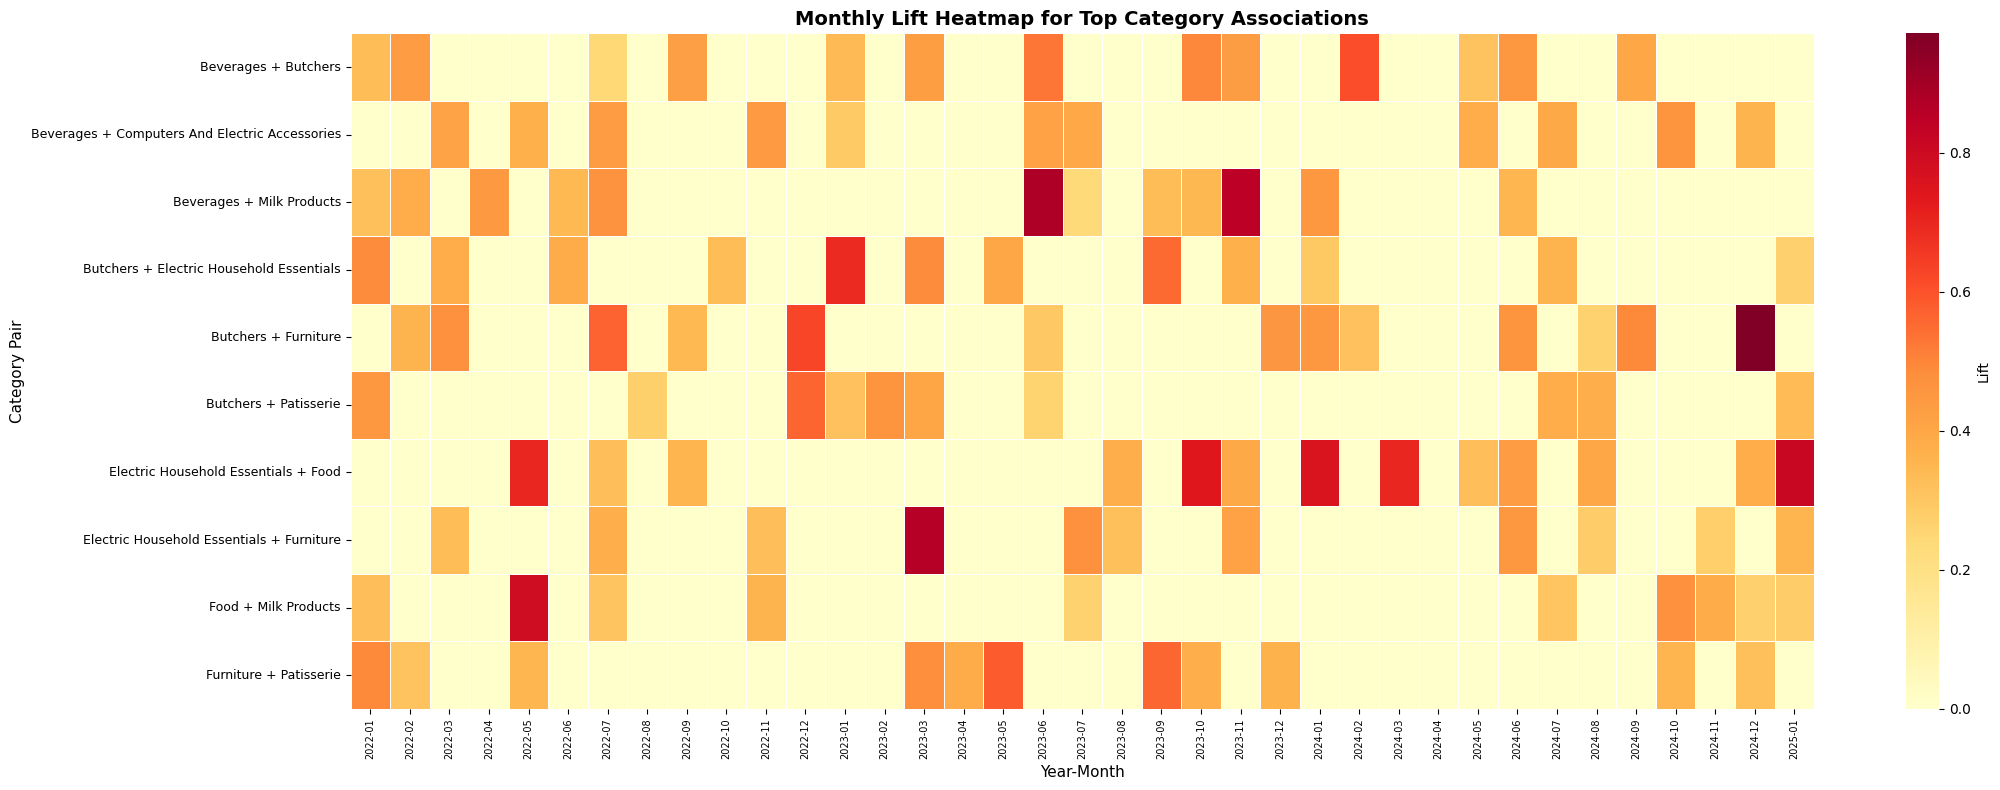

Saved: report/monthly_lift_heatmap.png


In [ ]:
# Visualization 4: Monthly lift heatmap for category associations
if len(all_monthly) > 0 and len(pair_counts) > 0:
    top_consistent = pair_counts.head(10)['pair'].tolist()

    heatmap_data = []
    for pair in top_consistent:
        pair_monthly = all_monthly[all_monthly['pair'] == pair].drop_duplicates(subset='year_month')
        pair_label = ' + '.join(pair)
        for ym in months_sorted:
            ym_str = str(ym)
            match = pair_monthly[pair_monthly['year_month'] == ym_str]
            lift_val = match['lift'].values[0] if len(match) > 0 else 0
            heatmap_data.append({'pair': pair_label, 'month': ym_str, 'lift': lift_val})

    heatmap_df = pd.DataFrame(heatmap_data)
    heatmap_pivot = heatmap_df.pivot(index='pair', columns='month', values='lift')

    fig, ax = plt.subplots(figsize=(22, 8))
    sns.heatmap(heatmap_pivot, cmap='YlOrRd', ax=ax, linewidths=0.5,
                cbar_kws={'label': 'Lift'}, vmin=0)
    ax.set_title('Monthly Lift Heatmap for Top Category Associations', fontsize=14, fontweight='bold')
    ax.set_xlabel('Year-Month', fontsize=11)
    ax.set_ylabel('Category Pair', fontsize=11)
    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(REPORT_VIZ_DIR, 'monthly_lift_heatmap.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: report/monthly_lift_heatmap.png')
else:
    print('No monthly data available for heatmap.')

In [15]:
# Save results for the mining report
# Top 5 product associations
top5_report = top5[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'pair']].copy()
top5_report['antecedents'] = top5_report['antecedents'].apply(lambda x: ', '.join(sorted(x)))
top5_report['consequents'] = top5_report['consequents'].apply(lambda x: ', '.join(sorted(x)))
top5_report['pair'] = top5_report['pair'].apply(lambda x: ' + '.join(x))
top5_report.to_csv(os.path.join(REPORT_DATA_DIR, 'top5_associations.csv'), index=False)

# Top category associations
cat_report = top_cat_unique[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'pair']].copy()
cat_report['antecedents'] = cat_report['antecedents'].apply(lambda x: ', '.join(sorted(x)))
cat_report['consequents'] = cat_report['consequents'].apply(lambda x: ', '.join(sorted(x)))
cat_report['pair'] = cat_report['pair'].apply(lambda x: ' + '.join(x))
cat_report.to_csv(os.path.join(REPORT_DATA_DIR, 'category_associations.csv'), index=False)

# Monthly consistency
if len(pair_counts) > 0:
    pc_report = pair_counts.copy()
    pc_report['pair'] = pc_report['pair'].apply(lambda x: ' + '.join(x))
    pc_report.to_csv(os.path.join(REPORT_DATA_DIR, 'monthly_consistency.csv'), index=False)

print('Results saved to report/ directory')

Results saved to report/ directory


In [16]:
# Final Summary
print('='*70)
print('MARKET BASKET ANALYSIS SUMMARY')
print('='*70)
print(f'Total baskets analyzed: {len(product_baskets)}')
print(f'Baskets with 2+ products: {(product_baskets["unique_count"] >= 2).sum()}')
print(f'Product-level rules found: {len(prod_rules)}')
print(f'Category-level rules found: {len(cat_rules)}')
print(f'Category-level monthly: rules in {len(monthly_results)}/{total_months} months')
print(f'Product-level monthly: rules in {months_with_prod_rules}/{prod_total_months} months')
print()
print('Top 5 Product Associations (by Lift):')
for i, (_, row) in enumerate(top5.iterrows(), 1):
    ant = ', '.join(sorted(row['antecedents']))
    con = ', '.join(sorted(row['consequents']))
    print(f"  {i}. {ant} -> {con}")
    print(f"     Support={row['support']:.4f}, Confidence={row['confidence']:.4f}, Lift={row['lift']:.4f}")
print()
print('Top 5 Category Associations (by Lift):')
for i, (_, row) in enumerate(top_cat_unique.head(5).iterrows(), 1):
    ant = ', '.join(sorted(row['antecedents']))
    con = ', '.join(sorted(row['consequents']))
    print(f"  {i}. {ant} -> {con}")
    print(f"     Support={row['support']:.4f}, Confidence={row['confidence']:.4f}, Lift={row['lift']:.4f}")

MARKET BASKET ANALYSIS SUMMARY
Total baskets analyzed: 10257
Baskets with 2+ products: 1032
Product-level rules found: 96
Category-level rules found: 56
Category-level monthly: rules in 37/37 months
Product-level monthly: rules in 37/37 months

Top 5 Product Associations (by Lift):
  1. Item_9_Milk -> Item_11_Milk
     Support=0.0002, Confidence=0.2000, Lift=19.3528
  2. Item_10_Bev -> Item_11_Food
     Support=0.0002, Confidence=0.0870, Lift=11.8922
  3. Item_22_But -> Item_19_Pat
     Support=0.0003, Confidence=0.0300, Lift=11.8350
  4. Item_1_Fur -> Item_18_Milk
     Support=0.0002, Confidence=0.0339, Lift=7.5586
  5. Item_21_Bev -> Item_7_Bev
     Support=0.0002, Confidence=0.0465, Lift=6.6260

Top 5 Category Associations (by Lift):
  1. Food -> Electric Household Essentials
     Support=0.0045, Confidence=0.0327, Lift=0.2360
  2. Beverages -> Butchers
     Support=0.0042, Confidence=0.0306, Lift=0.2239
  3. Milk Products -> Beverages
     Support=0.0042, Confidence=0.0306, Lift=0.